### Importing libraries

In [78]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import psycopg2
import os
from collections import Counter
import unidecode
import re
import requests
from datetime import timedelta

### Downloading the data to be analyzed

In [56]:
conn = psycopg2.connect(
    host="database_container1000",
    database=os.environ.get('POSTGRES_DB'),
    user=os.environ.get('POSTGRES_USER'),
    password=os.environ.get('POSTGRES_PASSWORD')
)

query = "SELECT * FROM new_offers"
df = pd.read_sql_query(query, conn)

/tmp/ipykernel_144/3919701789.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


### Displaying a sample of downloaded data

In [57]:
df.head()

,id,offer_link,offer_name,company,main_location,other_location,salary,salary_type,main_requirements_description,main_offer_description,...,benefits,company_foundation_year,company_size,company_head_office_place,date_of_scrapping,when_published_relatively,categories,skills_maturity,tags_mandatory,tags_nice_to_have
0,1,https://nofluffjobs.com/pl/job/senior-python-d...,Senior Python/Data Software Engineer,SmartRecruiters Inc.,"Kraków, Fabryczna 20A",Zdalnie,21 000 – 28 500,+ VAT (B2B) miesięcznie,"Opis wymagań, Oryginalny tekst., Pokaż tłumacz...","Opis oferty, Oryginalny tekst., Pokaż tłumacze...",...,"Pakiet sportowy, Prywatna opieka medyczna, Mał...",<None>,<None>,<None>,2023-11-21,Oferta opublikowana dzisiaj,"Backend, Python",Senior,<None>,<None>
1,2,https://nofluffjobs.com/job/senior-python-data...,Senior Python/Data Software Engineer,SmartRecruiters Inc.,"Kraków, Fabryczna 20A",Remote,21 000 – 28 500,+ VAT (B2B) per month,Experience in back-end development using Pytho...,"SmartRecruiters, is building an operating syst...",...,"Sport subscription, Private healthcare, Small ...",2009,480,<None>,2023-11-21,today,"Backend, Python",Senior,"Python, AWS, MongoDB, Docker, Kubernetes, Kafk...","Kibana, Grafana, Prometheus"
2,3,https://nofluffjobs.com/job/ml-python-nlp-engi...,ML (Python + NLP) Engineer,SFox,<None>,Remote,13 104 – 21 840,+ VAT (B2B) per month,"On behalf of our client in Sweden, we’re looki...","What we offer:, Scandinavian work-life balance...",...,"Small teams, International projects",2018,30+,Zug,2023-11-21,This offer expires in 1 day,"AI, Python",Senior,"Python, AI, R&D, Accounting, React, Microservi...",<None>
3,4,https://nofluffjobs.com/job/ml-python-nlp-engi...,ML (Python + NLP) Engineer,SFox,<None>,Remote,13 094 – 21 823,+ VAT (B2B) per month,"On behalf of our client in Sweden, we’re looki...","What we offer:, Scandinavian work-life balance...",...,"Small teams, International projects",2018,30+,Zug,2023-11-21,This offer expires in 1 day,"AI, Python",Senior,"Python, AI, R&D, Accounting, React, Microservi...",<None>
4,5,https://nofluffjobs.com/job/python-test-develo...,Python Test Developer,Sii Polska,Hybrid,<None>,17 000 – 24 000,+ VAT (B2B) per month,At least 3 years of experience as a Python Aut...,We are looking for Candidate who want to join ...,...,"Training budget, Private healthcare, Small teams",2006,8000,<None>,2023-11-21,5 days ago,"Testing, Python",Senior,"Python, API, GitLab, SAFe, Robot Framework","AWS, PostgreSQL, CI/CD, Linux"


### Number of IT job offers for various offer names and various key words (Junior, Senior, etc.) 

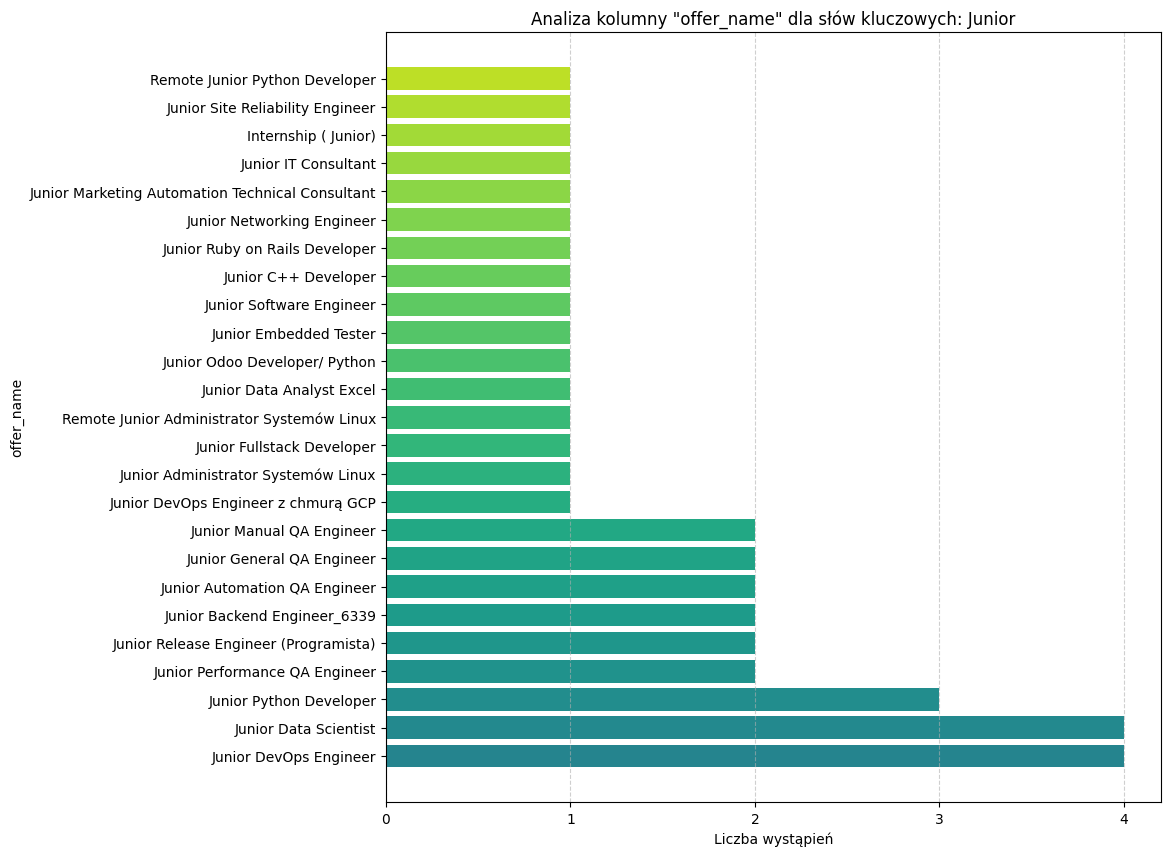

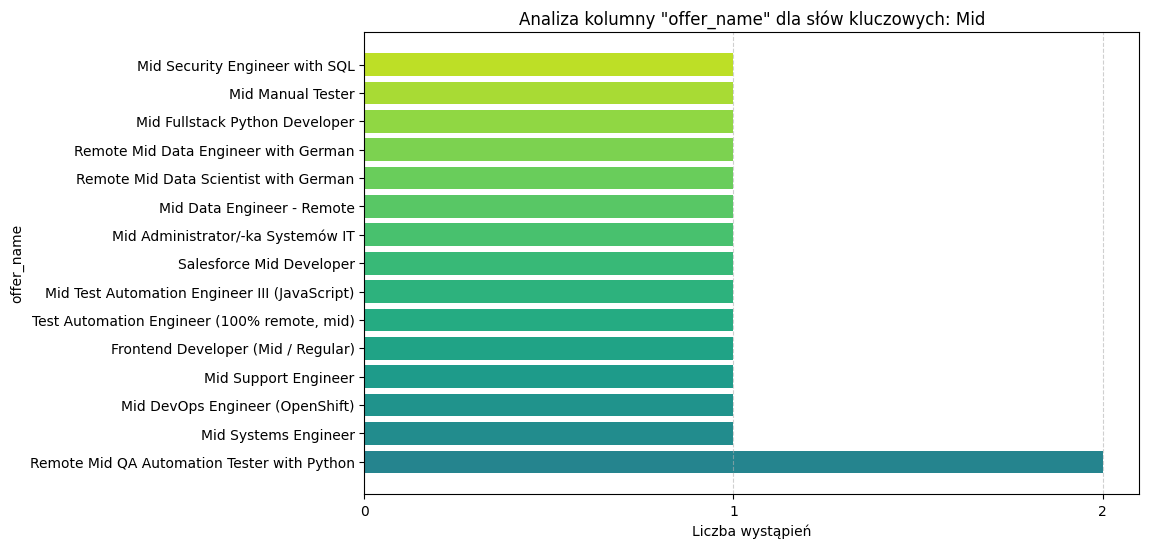

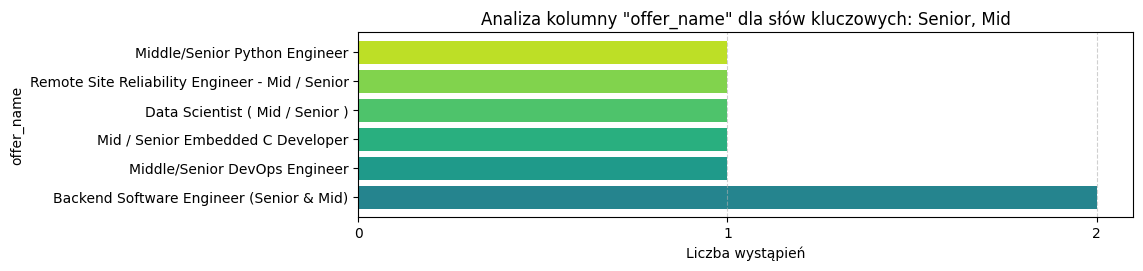

In [77]:
def analyze_column_by_keywords(dataframe, column_name, *keywords, **kwargs):
    unwanted_keywords = kwargs.get('unwanted_keywords', [])
    
    # Sprawdź, czy kolumna istnieje w ramce danych
    if column_name not in dataframe.columns:
        print(f'Kolumna "{column_name}" nie istnieje w ramce danych.')
        return

    # Filtruj dane według słów kluczowych
    filtered_df = dataframe.copy()
    for keyword in keywords:
        filtered_df = filtered_df[filtered_df[column_name].str.contains(keyword, case=False, na=False)]
    
    # Wyklucz niepożądane słowa kluczowe
    for unwanted in unwanted_keywords:
        filtered_df = filtered_df[~filtered_df[column_name].str.contains(unwanted, case=False, na=False)]
    
    # Jeśli nie ma żadnych dopasowań, zwróć
    if filtered_df.empty:
        print(f'Brak dopasowań dla słów kluczowych: {", ".join(keywords)}')
        return

    # Zliczanie wystąpień unikatowych wartości
    value_counts = filtered_df[column_name].value_counts()
    
    # Określ liczbę pozycji
    num_items = len(value_counts)

    # Ustal wysokość wykresu
    height_per_item = 0.4
    total_height = num_items * height_per_item

    # Tworzenie wizualizacji
    plt.figure(figsize=(10, total_height))
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Generowanie palety kolorów
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, num_items))

    # Użycie palety kolorów w wykresie
    plt.barh(value_counts.index, value_counts.values, color=colors)
    plt.ylabel(column_name)
    plt.xlabel('Liczba wystąpień')
    plt.title(f'Analiza kolumny "{column_name}" dla słów kluczowych: {", ".join(keywords)}')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

def analyze_other_offers(dataframe, column_name, *unwanted_keywords):
    # Sprawdź, czy kolumna istnieje w ramce danych
    if column_name not in dataframe.columns:
        print(f'Kolumna "{column_name}" nie istnieje w ramce danych.')
        return

    # Wyklucz niepożądane słowa kluczowe
    filtered_df = dataframe.copy()
    for unwanted in unwanted_keywords:
        filtered_df = filtered_df[~filtered_df[column_name].str.contains(unwanted, case=False, na=False)]
    
    # Jeśli nie ma żadnych dopasowań, zwróć
    if filtered_df.empty:
        print(f'Brak dopasowań dla kategorii "Inne oferty".')
        return

    # Zliczanie wystąpień unikatowych wartości
    value_counts = filtered_df[column_name].value_counts()
    
    # Określ liczbę pozycji
    num_items = len(value_counts)

    # Ustal wysokość wykresu
    height_per_item = 0.4
    total_height = num_items * height_per_item

    
    # Tworzenie wizualizacji
    plt.figure(figsize=(10, total_height))
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Generowanie palety kolorów
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, num_items))

    # Użycie palety kolorów w wykresie
    plt.barh(value_counts.index, value_counts.values, color=colors)
    plt.ylabel(column_name)
    plt.xlabel('Liczba wystąpień')
    plt.title(f'Analiza kolumny "{column_name}" dla kategorii "Inne oferty"')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


# Wywołanie funkcji (wybrane)
analyze_column_by_keywords(df, 'offer_name', 'Junior', unwanted_keywords=['Mid', 'Senior'])
analyze_column_by_keywords(df, 'offer_name', 'Mid', unwanted_keywords=['Junior', 'Senior'])
#analyze_column_by_keywords(df, 'offer_name', 'Senior', unwanted_keywords=['Junior', 'Mid'])
#analyze_column_by_keywords(df, 'offer_name', 'Junior', 'Mid', unwanted_keywords=['Senior'])
analyze_column_by_keywords(df, 'offer_name', 'Senior', 'Mid', unwanted_keywords=['Junior'])
#analyze_column_by_keywords(df, 'offer_name', 'Junior', 'Mid', 'Senior')

# Wywołanie funkcji dla kategorii "Inne oferty"
#analyze_other_offers(df, 'offer_name', 'Junior', 'Mid', 'Senior')



### 

### Number of job offers by company. Each colour symbolises another offer name. The plots includes and/or excludes the chosen keywords

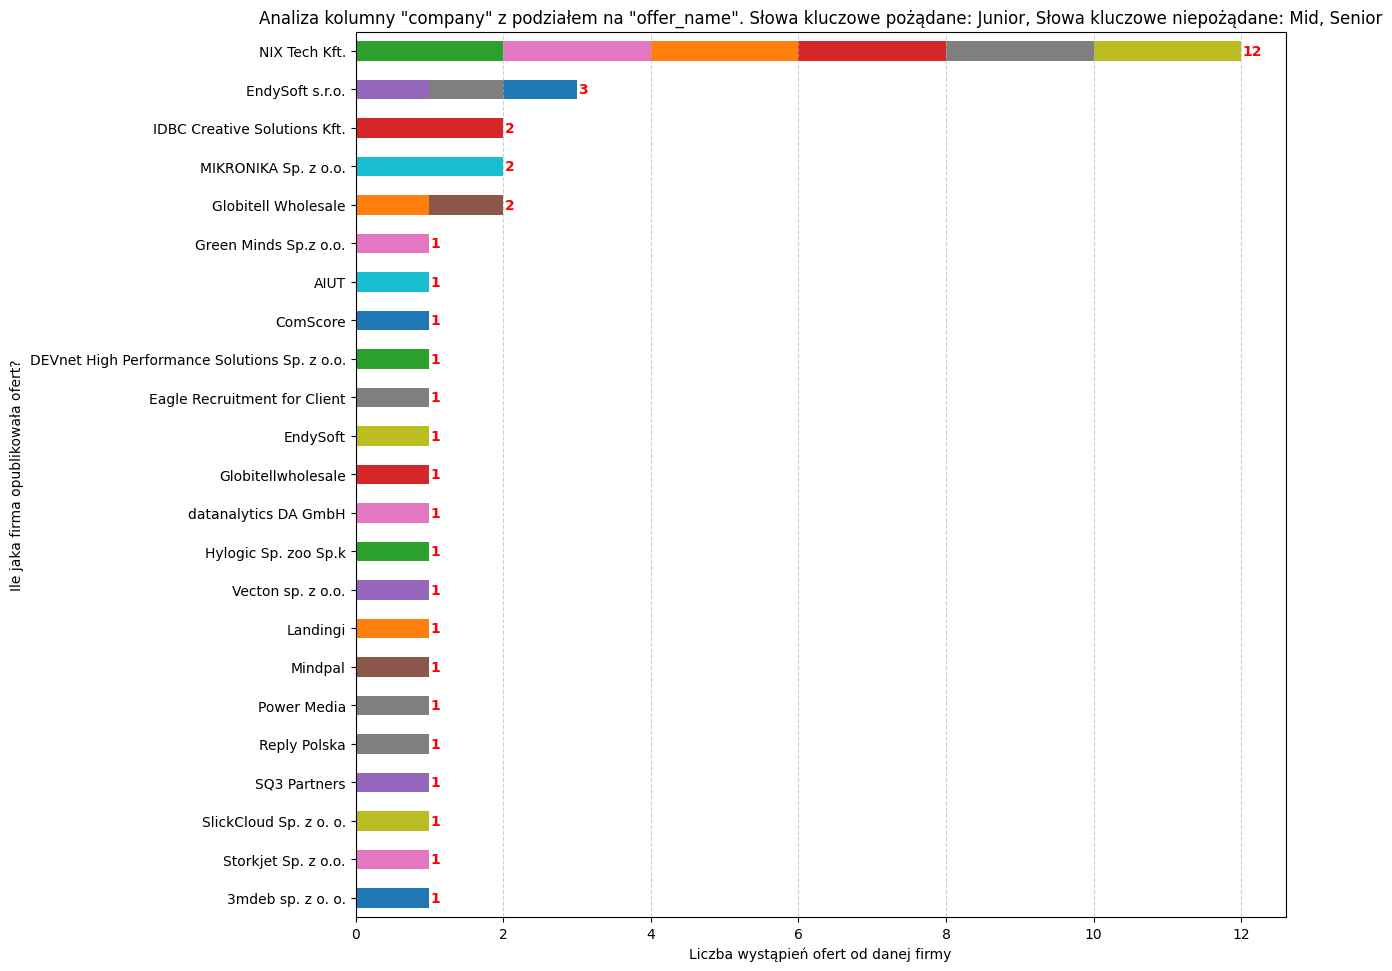

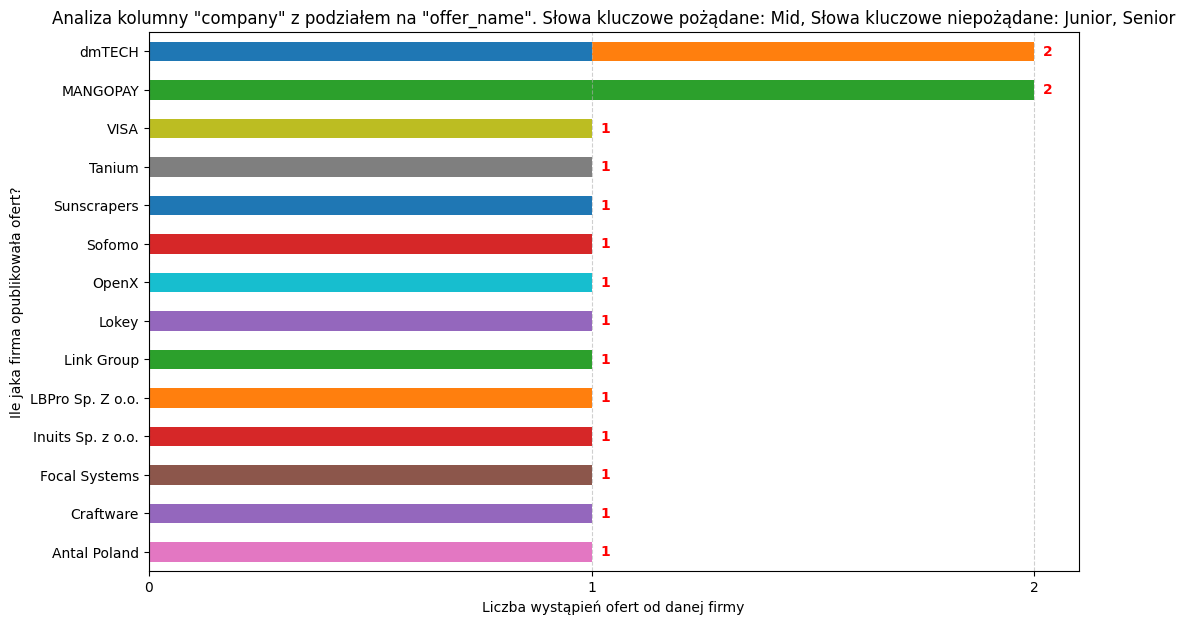

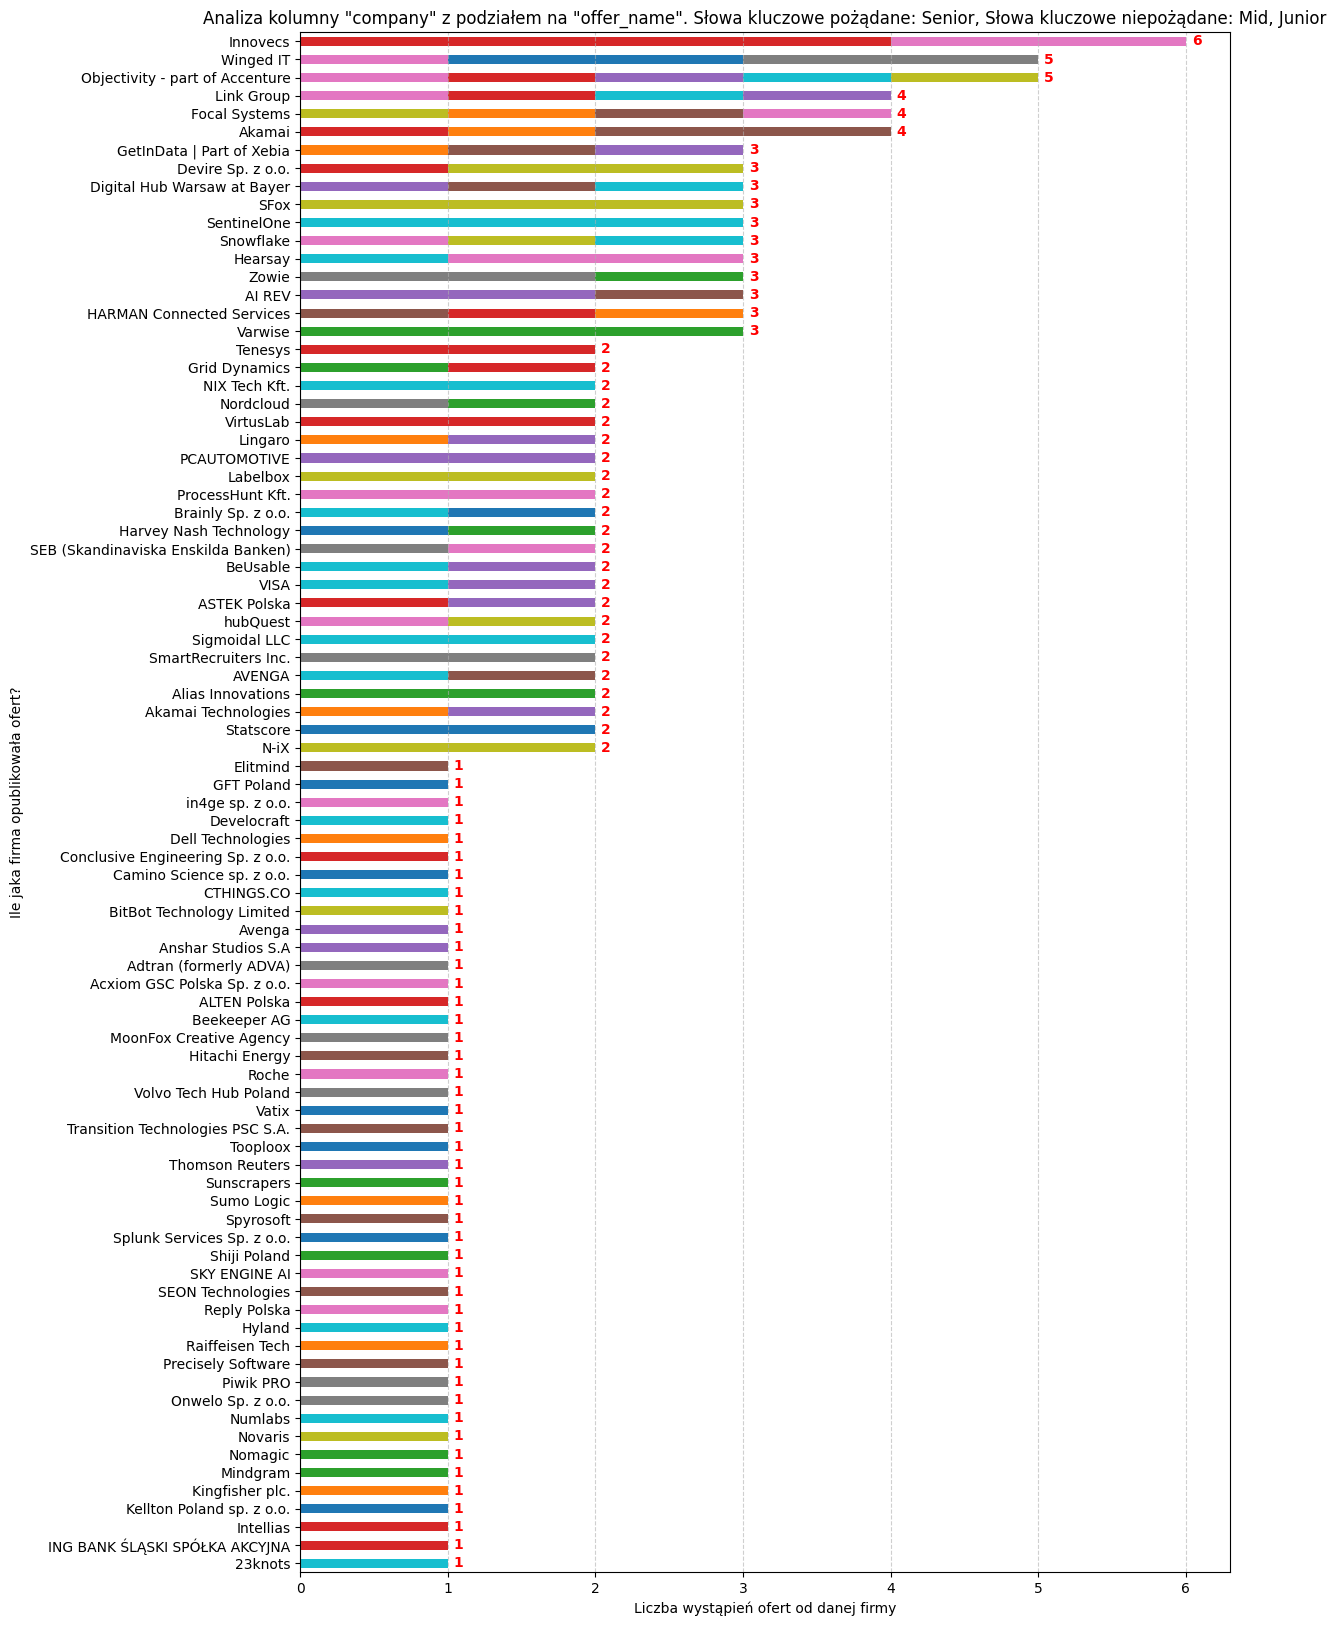

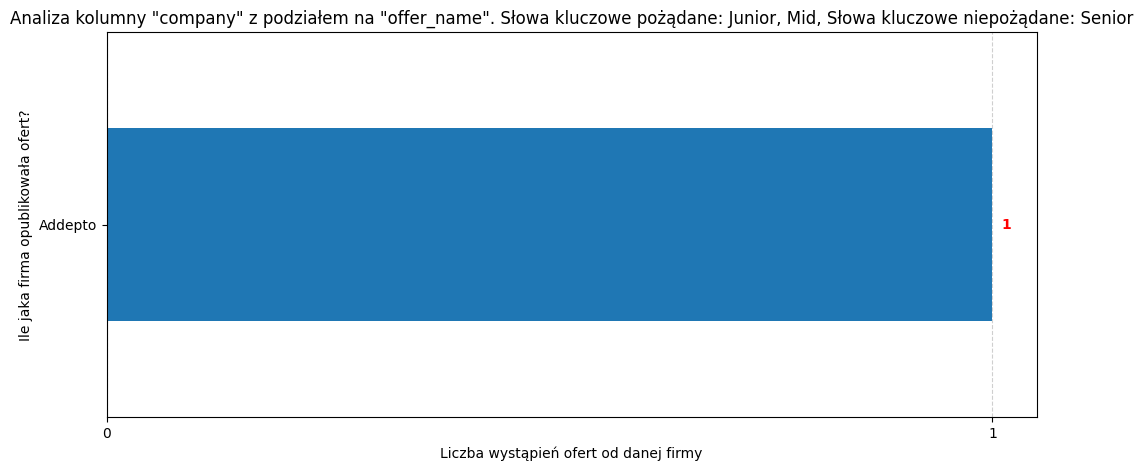

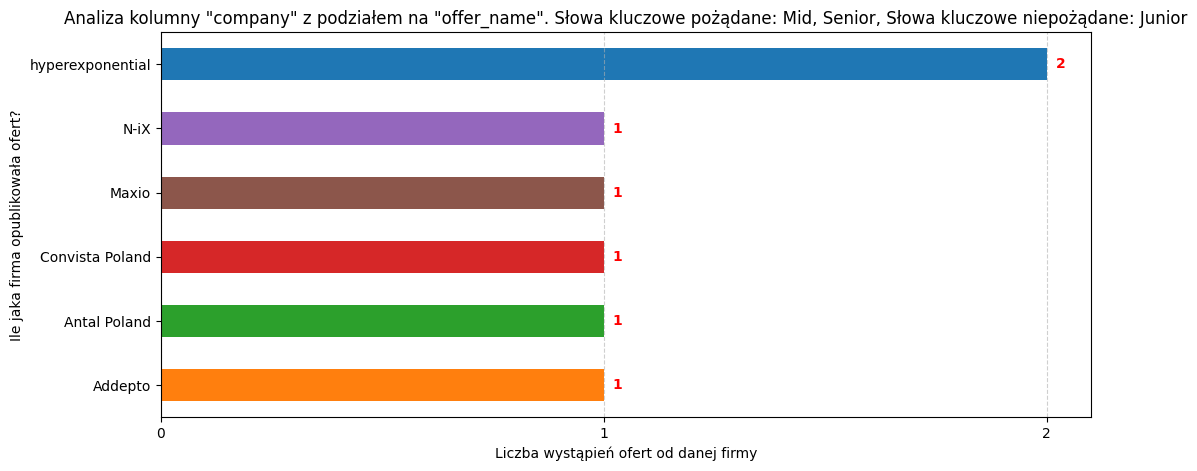

In [59]:
def analyze_column_company_with_offer_names(dataframe, column_name="company", offer_column_name="offer_name", *keywords, **kwargs):
    unwanted_keywords = kwargs.get('unwanted_keywords', [])
    keywords_str = ', '.join(keywords)
    unwanted_keywords_str = ', '.join(unwanted_keywords)
    
    # Sprawdź, czy kolumna istnieje w ramce danych
    if column_name not in dataframe.columns:
        print(f'Kolumna "{column_name}" nie istnieje w ramce danych.')
        return

    # Sprawdź, czy kolumna z nazwami ofert istnieje w ramce danych
    if offer_column_name not in dataframe.columns:
        print(f'Kolumna "{offer_column_name}" nie istnieje w ramce danych.')
        return

    # Filtruj dane według słów kluczowych
    filtered_df = dataframe.copy()
    if keywords:  # Jeśli podano pożądane słowa kluczowe
        for keyword in keywords:
            filtered_df = filtered_df[filtered_df[offer_column_name].str.contains(keyword, case=False, na=False)]
    
    # Wyklucz niepożądane słowa kluczowe
    for unwanted in unwanted_keywords:
        filtered_df = filtered_df[~filtered_df[offer_column_name].str.contains(unwanted, case=False, na=False)]
    
    # Grupowanie danych według kolumny i kolumny z nazwami ofert, a następnie zliczanie wielkości każdej grupy
    grouped_data = filtered_df.groupby([column_name, offer_column_name]).size().unstack(fill_value=0)


    if grouped_data.empty:
        print(f'Brak danych do wyświetlenia dla podanych słów kluczowych pożądanych: {keywords_str}, i niepożądanych: {unwanted_keywords_str}')
        return


    # Obliczenie łącznej liczby ofert dla każdej firmy
    total_offers = grouped_data.sum(axis=1)

    # Sortuj według total_offers
    sorted_index = total_offers.sort_values().index
    grouped_data = grouped_data.reindex(sorted_index)
    total_offers = total_offers.reindex(sorted_index)


    # Określ liczbę pozycji
    num_items = len(total_offers)

    # Ustal wysokość wykresu
    height_per_item = 0.5
    total_height = num_items * height_per_item

    # Ustal minimalną i maksymalną wysokość
    min_height = 5
    max_height = 20

    # Dostosuj wysokość wykresu
    total_height = max(min_height, min(total_height, max_height))
    
    # Tworzenie wizualizacji
    plt.figure(figsize=(12, total_height))
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Rysowanie poziomego wykresu słupkowego z podgrupami
    grouped_data.plot(kind='barh', stacked=True, ax=ax, legend=False)
    
    # Dodanie łącznej liczby ofert jako tekst na wykresie
    for i, total in enumerate(total_offers):
        plt.text(total + grouped_data.max().max() * 0.01, i, str(total), va='center', color='red', fontweight='bold', fontsize=10)
    
    plt.ylabel('Ile jaka firma opublikowała ofert?')
    plt.xlabel('Liczba wystąpień ofert od danej firmy')

    plt.title(f'Analiza kolumny "{column_name}" z podziałem na "{offer_column_name}". Słowa kluczowe pożądane: {keywords_str}, Słowa kluczowe niepożądane: {unwanted_keywords_str}')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    plt.show()

# Przykładowe wywołania funkcji
analyze_column_company_with_offer_names(df, 'company', 'offer_name', 'Junior', unwanted_keywords=['Mid', 'Senior'])
analyze_column_company_with_offer_names(df, 'company', 'offer_name', 'Mid', unwanted_keywords=['Junior', 'Senior'])
analyze_column_company_with_offer_names(df, 'company', 'offer_name', 'Senior', unwanted_keywords=['Mid', 'Junior'])
analyze_column_company_with_offer_names(df, 'company', 'offer_name', 'Junior', 'Mid', unwanted_keywords=['Senior'])
analyze_column_company_with_offer_names(df, 'company', 'offer_name', 'Mid', 'Senior', unwanted_keywords=['Junior'])
#analyze_column_company_with_offer_names(df, 'company', 'offer_name', 'Junior', 'Mid', 'Senior')
# Przykładowe wywołanie funkcji tylko z niepożądanymi słowami kluczowymi
#analyze_column_company_with_offer_names(df, 'company', 'offer_name', unwanted_keywords=['Junior', 'Mid', 'Senior'])
# Przykładowe wywołanie funkcji bez podawania żadnych słów kluczowych
#analyze_column_company_with_offer_names(df, 'company', 'offer_name')


##RÓŻNE KOLORY I ICH DŁUGOŚĆ NA KOLUMNIE OFERT DANEJ FIRMY ZNACZĄ RODZAJE OFERT I ICH LICZEBNOŚĆ


### Job offers work locations

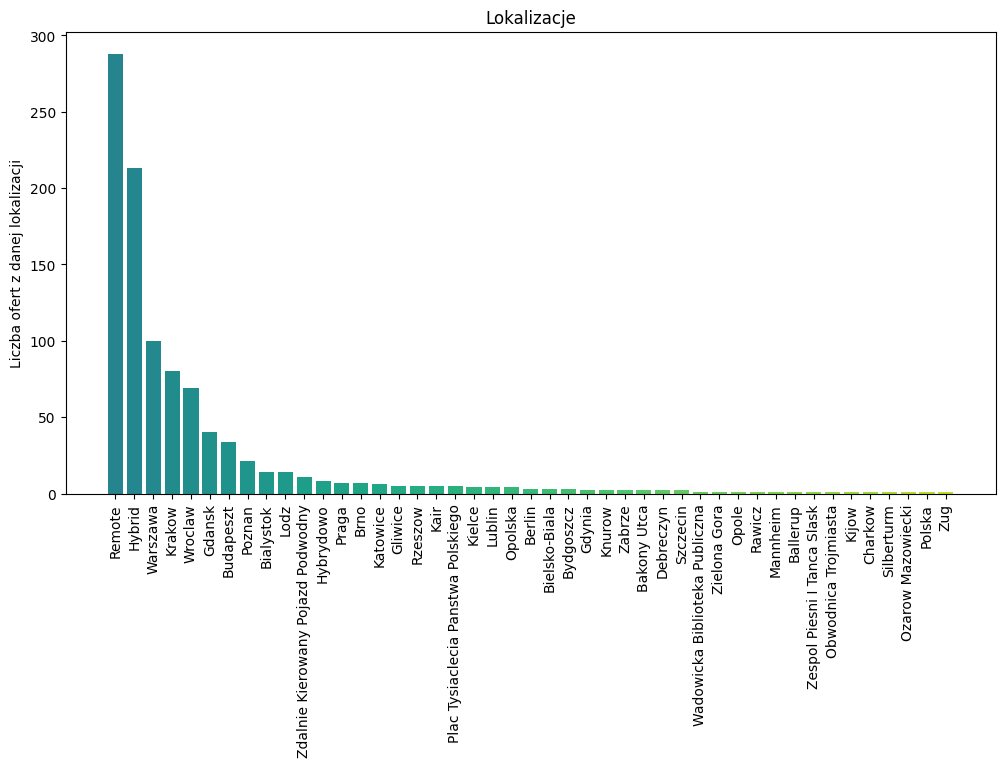

In [60]:
def format_location(loc):
    # Normalizacja myślników i usuwanie dodatkowych spacji
    loc = re.sub(r'\s*-\s*', '-', loc)
    # Usuwanie polskich znaków i formatowanie frazy
    return unidecode.unidecode(loc).title()

def get_polish_name(city_name):
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "language": "en",
        "format": "json",
        "search": city_name
    }
    response = requests.get(url, params=params)
    results = response.json().get('search')

    if not results:
        return None

    city_id = results[0].get('id')
    if not city_id:
        return None

    url = f"https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbgetentities",
        "ids": city_id,
        "format": "json",
        "props": "labels",
        "languages": "pl"
    }
    response = requests.get(url, params=params)
    data = response.json()

    polish_name = data['entities'][city_id]['labels'].get('pl')
    if polish_name:
        return polish_name.get('value')
    else:
        return None

def process_locations(counter):
    processed_counter = Counter()
    for loc, count in counter.items():
        # Pomijanie "Remote" i "Hybrid"
        if loc.lower() in ["remote", "hybrid"]:
            processed_counter[loc] += count
            continue

        polish_name = get_polish_name(loc)
        if polish_name:
            formatted_polish_name = format_location(polish_name)
            if formatted_polish_name in processed_counter:
                processed_counter[formatted_polish_name] += count
            else:
                processed_counter[formatted_polish_name] = count
        else:
            formatted_loc = format_location(loc)
            processed_counter[formatted_loc] += count

    return processed_counter

def location_joining(df):
    def join_locations(row):
        main_loc = row['main_location']
        other_loc = row['other_location']
        if main_loc == '<None>' and other_loc == '<None>':
            return '<none>'
        elif main_loc == '<None>':
            return other_loc
        elif other_loc == '<None>':
            return main_loc
        else:
            return f"{main_loc}, {other_loc}"

    df['location'] = df.apply(join_locations, axis=1)

    # Tworzenie pierwotnego licznika lokalizacji
    counter = Counter()
    for loc in df['location']:
        for sub_loc in loc.split(", "):
            if not any(char.isdigit() for char in sub_loc):
                counter[sub_loc] += 1

    # Procesowanie i formatowanie licznika
    processed_counter = process_locations(counter)

    # Sortowanie danych w malejącej kolejności
    sorted_data = dict(sorted(processed_counter.items(), key=lambda x: x[1], reverse=True))
    
    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba ofert z danej lokalizacji')
    plt.title('Lokalizacje')
    plt.show()

location_joining(df)


### Salaries by seniority and by specific offer name (huge plot, temporarly commented and disabled because it is overloaded with data)

In [ ]:
#ZAKOMENTOWANY KOD, KTÓRY W RAZIE CZEGO POKAZUJE PENSJE DLA POSZCZEGÓLNYCH NAZW STANOWISK

# def average_salary(df, *keywords, **kwargs):
    
#     unwanted_keywords = kwargs.get('unwanted_keywords', [])
    
#     # Filtruj dane według słów kluczowych
#     filtered_df = df.copy()
#     if keywords:  # Jeśli podano pożądane słowa kluczowe
#         for keyword in keywords:
#             filtered_df = filtered_df[filtered_df['offer_name'].str.contains(keyword, case=False, na=False)]
    
#     # Wyklucz niepożądane słowa kluczowe
#     for unwanted in unwanted_keywords:
#         filtered_df = filtered_df[~filtered_df['offer_name'].str.contains(unwanted, case=False, na=False)]

#     # Jeśli po filtracji nie ma żadnych danych, wyświetl komunikat
#     if filtered_df.empty:
#         print(f"Nie znaleziono żadnych ofert dla słów pożądanych: {', '.join(keywords)} i niepożądanych: {', '.join(unwanted_keywords)}")
#         return

#     sum_variables_lower = {}
#     sum_variables_upper = {}
#     number_in_variables_type = {}

#     for index, row in filtered_df.iterrows():
#         # Usuwanie niecyfrowych znaków i podział wartości salary
#         salary_values = row['salary'].split("–")
#         salary_range = [re.sub(r'\D', '', x) for x in salary_values]

#         # Tworzenie nazw zmiennych
#         var_name = f"{row['offer_name']} [{row['salary_type']}]"
#         lower_var_name = f"dolne_widelki_{row['offer_name']} [{row['salary_type']}]"
#         upper_var_name = f"gorne_widelki_{row['offer_name']} [{row['salary_type']}]"
#         no_range_var_name = f"srednia_bez_widelek_{row['offer_name']} [{row['salary_type']}]"

#         if len(salary_range) > 1:
#             # Sumowanie wartości do odpowiednich zmiennych (jeśli mamy widełki płacowe), oraz liczymy liczbę wystąpień danego typu wynagrodzeń
#             sum_variables_lower[var_name] = sum_variables_lower.get(lower_var_name, 0) + int(salary_range[0])
#             number_in_variables_type[var_name] = number_in_variables_type.get(lower_var_name, 0) + 1

#             sum_variables_upper[var_name] = sum_variables_upper.get(upper_var_name, 0) + int(salary_range[1])            
#         else:
#             # Dodawanie wartości do zmiennej dla ofert bez widełek płacowych
#             sum_variables_lower[no_range_var_name] = sum_variables_lower.get(no_range_var_name, 0) + int(salary_range[0])
#             sum_variables_upper[no_range_var_name] = sum_variables_upper.get(no_range_var_name, 0) + int(salary_range[0])
#             number_in_variables_type[no_range_var_name] = number_in_variables_type.get(no_range_var_name, 0) + 1

#     # Wyliczanie średniej wartości parametrów, na bazie dwóch słowników
#     def divide_dict_values(dict_X, dict_Y):
#         """
#         Dzieli wartości słownika dict_X przez wartości słownika dict_Y 
#         dla każdego klucza i zwraca nowy słownik z wynikami.

#         :param dict_X: Słownik z dzielnikami
#         :param dict_Y: Słownik z dzielnymi
#         :return: Słownik z wynikami dzielenia
#         """
#         if set(dict_X.keys()) != set(dict_Y.keys()):
#             raise ValueError("Słowniki mają różne zbiory kluczy")

#         result_dict = {}
#         for key in dict_X.keys():
#             if dict_Y[key] == 0:
#                 raise ValueError(f"Wartość dla klucza '{key}' w słowniku dict_Y jest równa zero, dzielenie niemożliwe")
#             result_dict[key] = dict_X[key] / dict_Y[key]

#         return result_dict

#     average_values_lower = divide_dict_values(sum_variables_lower, number_in_variables_type)
#     average_values_upper = divide_dict_values(sum_variables_upper, number_in_variables_type)

#     # Tworzenie wykresu
#     preKeys = list(average_values_lower.keys())
#     values_lower = list(average_values_lower.values())
#     values_upper = list(average_values_upper.values())

#     keys = sorted(preKeys, key=lambda x: x[::-1], reverse=True)

#     def sorting_key(key):
#         # Określ pozycję klucza na wykresie w oparciu o wyrażenia
#         if "[+ VAT (B2B) per month]" in key:
#             position1 = 0
#         elif "[gross per month (employment)]" in key:
#             position1 = 1
#         else:
#             position1 = 2
    
#         # Określ pozycję klucza w oparciu o słowa "Junior", "Senior" itp.
#         if "Junior" in key:
#             position2 = 0
#         elif "Senior" in key:
#             position2 = 2
#         else:
#             position2 = 1
    
#         return (position1, position2)

#     # Posortuj klucze słownika keys używając zdefiniowanej funkcji klucza
#     sorted_keys = sorted(keys, key=sorting_key)
    
#     # Posortuj klucze słownika keys używając zdefiniowanej funkcji klucza
#     keys = sorted(keys, key=sorting_key)
    
#     # Dostosuj wysokość wykresu do liczby kolumn/zakresów do wyświetlenia
#     fig, ax = plt.subplots(figsize=(10, len(keys)*0.5))
        
#     i = 0
#     while i < len(keys):
#         if "srednia_bez_widelek" in keys[i]:
#             label = keys[i].replace("srednia_bez_widelek_", "Średnia, gdy bez widełek płacowych: ")            
#             ax.hlines(label, values_lower[i] - 90, values_lower[i] + 90, colors='red', linestyles='solid')
#             i += 1
#         else:
#             label = keys[i]
#             ax.hlines(label, values_lower[i], values_upper[i], colors='blue', linestyles='solid')
#             i += 1

#     ax.set_xlabel('Wynagrodzenie')
#     ax.set_ylabel('Nazwa stanowiska i typ pensji')
#     ax.set_title(f'Zakresy wynagrodzeń dla słów pożądanych: {", ".join(keywords)} i niepożądanych: {", ".join(unwanted_keywords)}')
#     ax.grid(axis='x')
#     plt.tight_layout()
#     plt.show()

# # Test funkcji
# average_salary(df, 'Junior', unwanted_keywords=['Mid', 'Senior'])
# average_salary(df, 'Mid', unwanted_keywords=['Junior', 'Senior'])
# average_salary(df, 'Senior', unwanted_keywords=['Mid', 'Junior'])
# average_salary(df, 'Junior', 'Mid', unwanted_keywords=['Senior'])
# average_salary(df, 'Mid', 'Senior', unwanted_keywords=['Junior'])
# average_salary(df, 'Junior', 'Mid', 'Senior')
# average_salary(df, unwanted_keywords=['Junior', 'Mid', 'Senior'])
# average_salary(df)

### Salaries by seniority (boxplots)

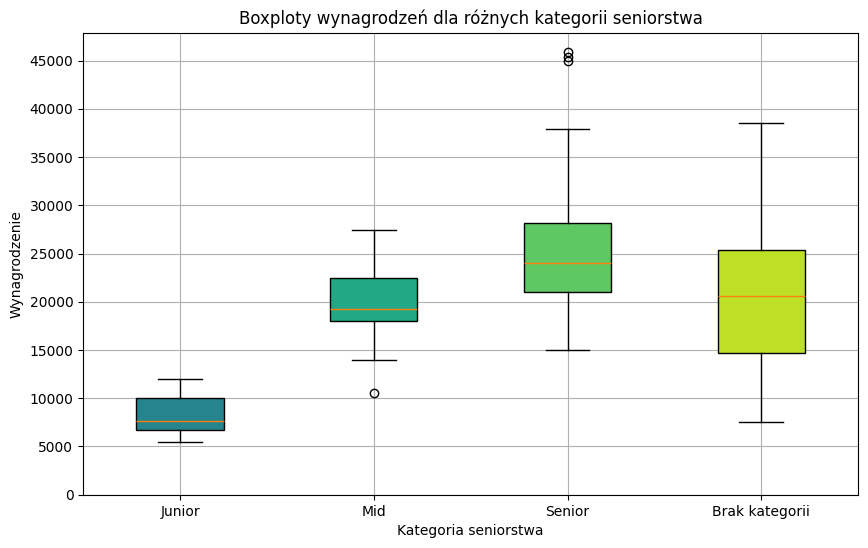

In [84]:
def average_salary(df, **kwargs):
    unwanted_keywords = kwargs.get('unwanted_keywords', [])

    # Filtruj dane według słów kluczowych
    filtered_df = df.copy()

    # Wyklucz niepożądane słowa kluczowe
    for unwanted in unwanted_keywords:
        filtered_df = filtered_df[~filtered_df['offer_name'].str.contains(unwanted, case=False, na=False)]

    if filtered_df.empty:
        print(f"Nie znaleziono żadnych ofert dla niepożądanych słów kluczowych: {', '.join(unwanted_keywords)}")
        return

    senior_categories = ['Junior', 'Mid', 'Senior', 'Brak kategorii']
    salary_data = {category: [] for category in senior_categories}

    for index, row in filtered_df.iterrows():
        salary_values = row['salary'].split("–")
        salary_range = [re.sub(r'\D', '', x) for x in salary_values]

        if len(salary_range) > 1:
            average_salary = (int(salary_range[0]) + int(salary_range[1])) / 2
        else:
            average_salary = int(salary_range[0])

        # Określanie kategorii seniorstwa
        if 'Junior' in row['offer_name']:
            category = 'Junior'
        elif 'Mid' in row['offer_name']:
            category = 'Mid'
        elif 'Senior' in row['offer_name']:
            category = 'Senior'
        else:
            category = 'Brak kategorii'

        salary_data[category].append(average_salary)

    # Filtruj dane na podstawie percentyli
    filtered_salary_data = {}
    for category, salaries in salary_data.items():
        if salaries:
            lower_percentile = np.percentile(salaries, 3)
            upper_percentile = np.percentile(salaries, 97)
            filtered_salary_data[category] = [salary for salary in salaries if lower_percentile <= salary <= upper_percentile]

    # Tworzenie wykresu boxplot
    boxplot_data = [filtered_salary_data[category] for category in senior_categories if filtered_salary_data[category]]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bplot = ax.boxplot(boxplot_data, labels=senior_categories, patch_artist=True)  # Użycie patch_artist=True

    # Generowanie palety kolorów
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(boxplot_data)))

    # Aplikowanie kolorów do poszczególnych pudełek
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_yticks(np.arange(0, max([max(data) for data in boxplot_data if data]), 5000))
    
    ax.set_xlabel('Kategoria seniorstwa')
    ax.set_ylabel('Wynagrodzenie')
    ax.set_title('Boxploty wynagrodzeń dla różnych kategorii seniorstwa')
    plt.grid(True)
    plt.show()

# Test funkcji
average_salary(df)

### The most popular salary types

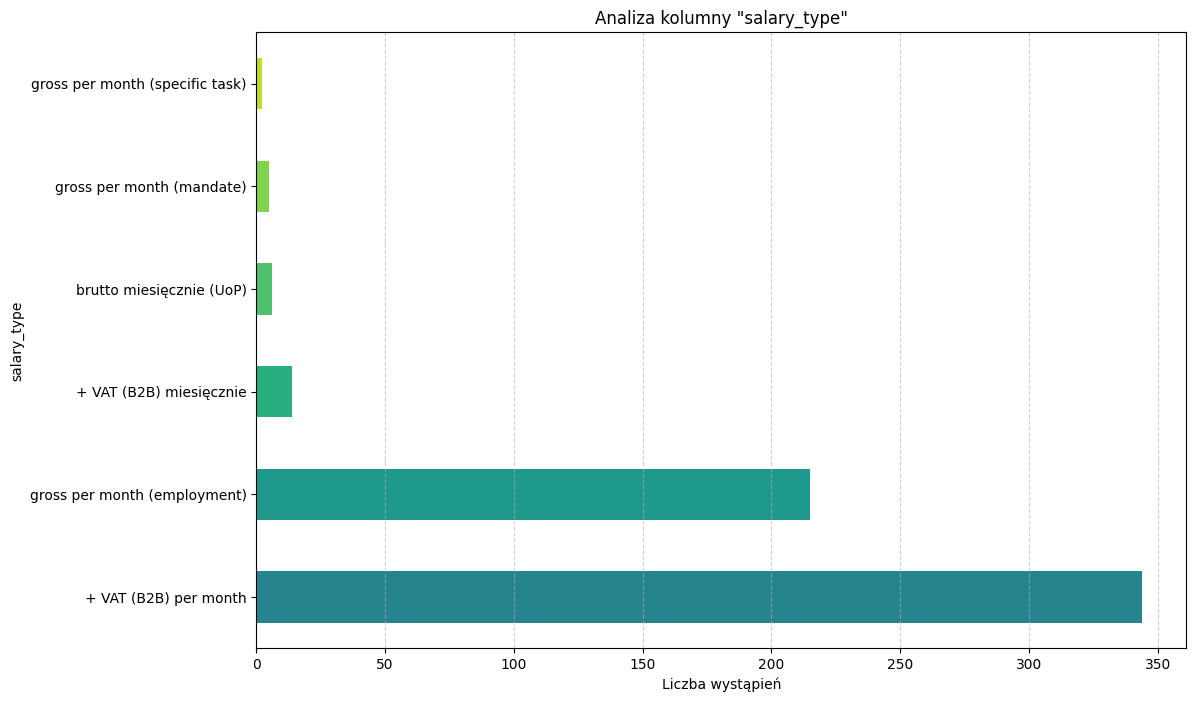

In [62]:
def analyze_column(dataframe, column_name):
    # Sprawdź, czy kolumna istnieje w ramce danych
    if column_name not in dataframe.columns:
        print(f'Kolumna "{column_name}" nie istnieje w ramce danych.')
        return

    # Zliczanie wystąpień unikatowych wartości
    value_counts = dataframe[column_name].value_counts()
    
    # Zliczenie częstości wystąpienia słów kluczowych
    keyword_counts = dataframe[column_name].value_counts()

    # Tworzenie wizualizacji
    plt.figure(figsize=(12, 8))

    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(keyword_counts)))

    # Użycie wygenerowanej palety kolorów dla słupków
    keyword_counts.plot(kind='barh', color=colors)
    
    plt.ylabel(column_name)
    plt.xlabel('Liczba wystąpień')
    plt.title(f'Analiza kolumny "{column_name}"')
    plt.grid(axis='x', linestyle='--', alpha=0.6)  # Zmiana osi siatki na 'x'
    plt.show()


analyze_column(df, 'salary_type')

### Offer details

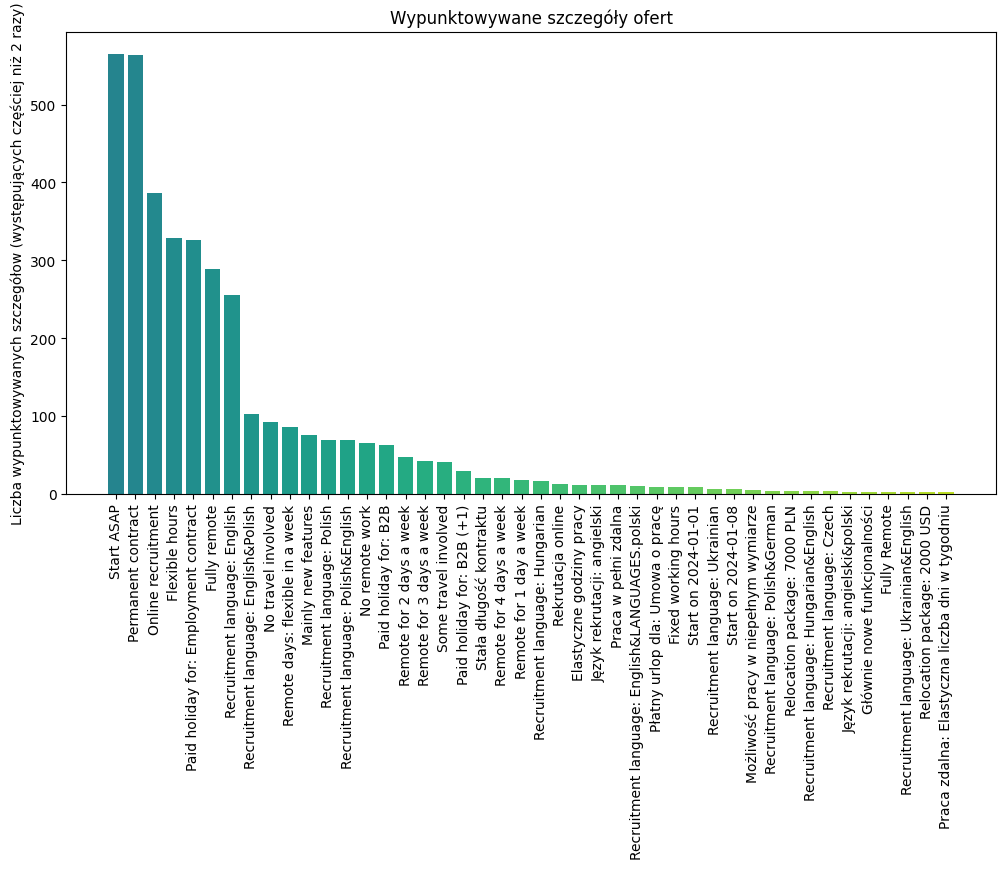

In [89]:
def offer_details_counter(df):
    counter = Counter()
    
    for loc in df['offer_details']:
        for sub_loc in loc.split(", "):
            counter[sub_loc] += 1

    # Filtruj tagi, które wystąpiły mniej niż 3 razy
    filtered_data = {k: v for k, v in counter.items() if v >= 3}

    # Sortuj dane w malejącej kolejności
    sorted_data = dict(sorted(filtered_data.items(), key=lambda x: x[1], reverse=True))
    
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba wypunktowywanych szczegółow (występujących częściej niż 2 razy)')
    plt.title('Wypunktowywane szczegóły ofert')
    plt.show()

offer_details_counter(df)


### The most popular IT work tools

/tmp/ipykernel_144/1379958816.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels)


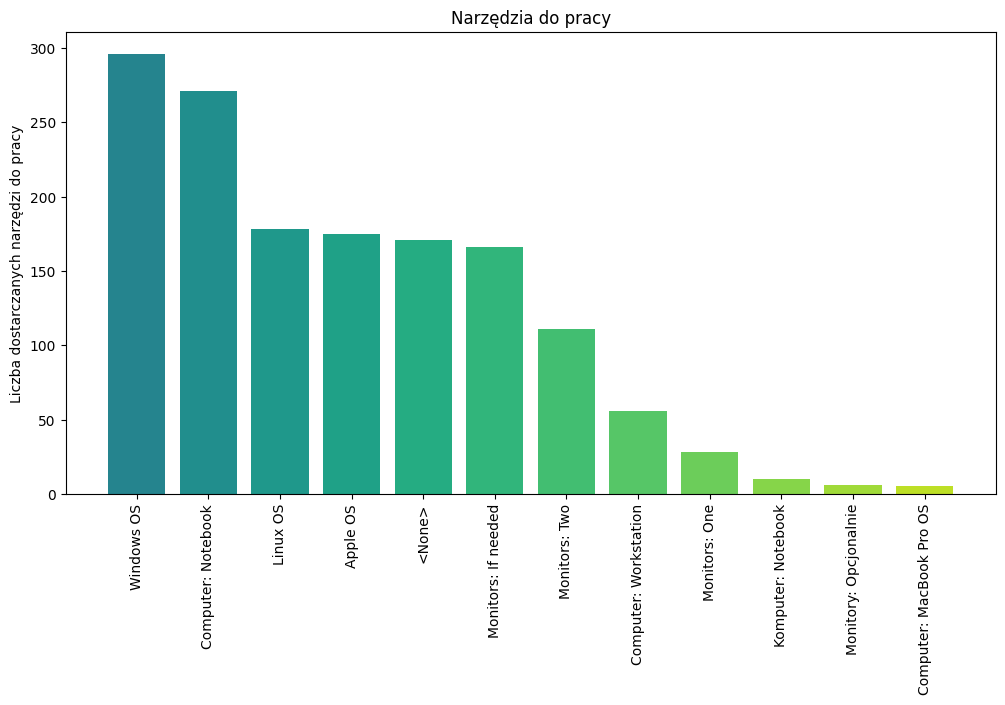

In [64]:
def eq_supplied_counter(df):
    counter = Counter()
    
    for loc in df['equipment_supplied']:
        for sub_loc in loc.split(", "):
            counter[sub_loc] += 1

    # Filtruj tagi, które wystąpiły mniej niż 5 razy
    filtered_data = {k: v for k, v in counter.items() if v >= 5}

    # Sortuj dane w malejącej kolejności
    sorted_data = dict(sorted(filtered_data.items(), key=lambda x: x[1], reverse=True))
    
    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba dostarczanych narzędzi do pracy')
    plt.title('Narzędzia do pracy')
    
    # Aktualizacja etykiet na osi X
    new_labels = []
    for label in plt.gca().get_xticklabels():
        for keyword in ["Windows", "Linux", "Mac", "Apple"]:
            if keyword.lower() in label.get_text().lower():
                new_labels.append(label.get_text() + " OS")
                break
        else:
            new_labels.append(label.get_text())

    plt.gca().set_xticklabels(new_labels)

    plt.show()

# Przykład użycia
eq_supplied_counter(df)



### The most popular metodologies used by work

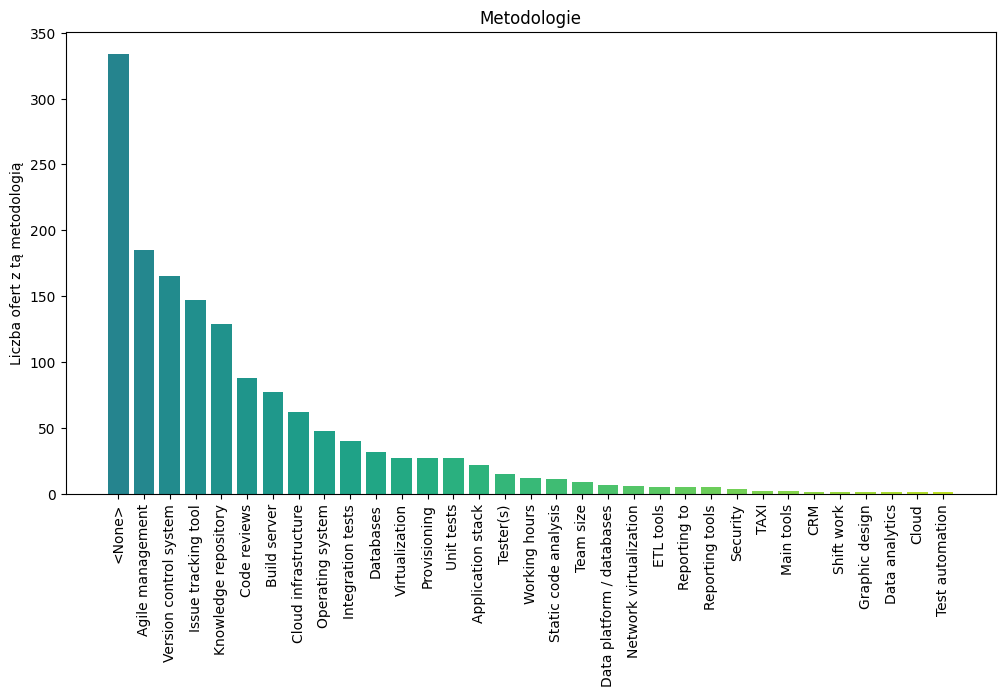

In [88]:
def methodology_ctr(df):
    counter = Counter()
    
    for loc in df['methodology']:
        for sub_loc in loc.split(", "):
            counter[sub_loc] += 1

    # Sortuj dane w malejącej kolejności
    sorted_data = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
    
    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba ofert z tą metodologią')
    plt.title('Metodologie')
    plt.show()

methodology_ctr(df)


### Office benefits for IT jobs

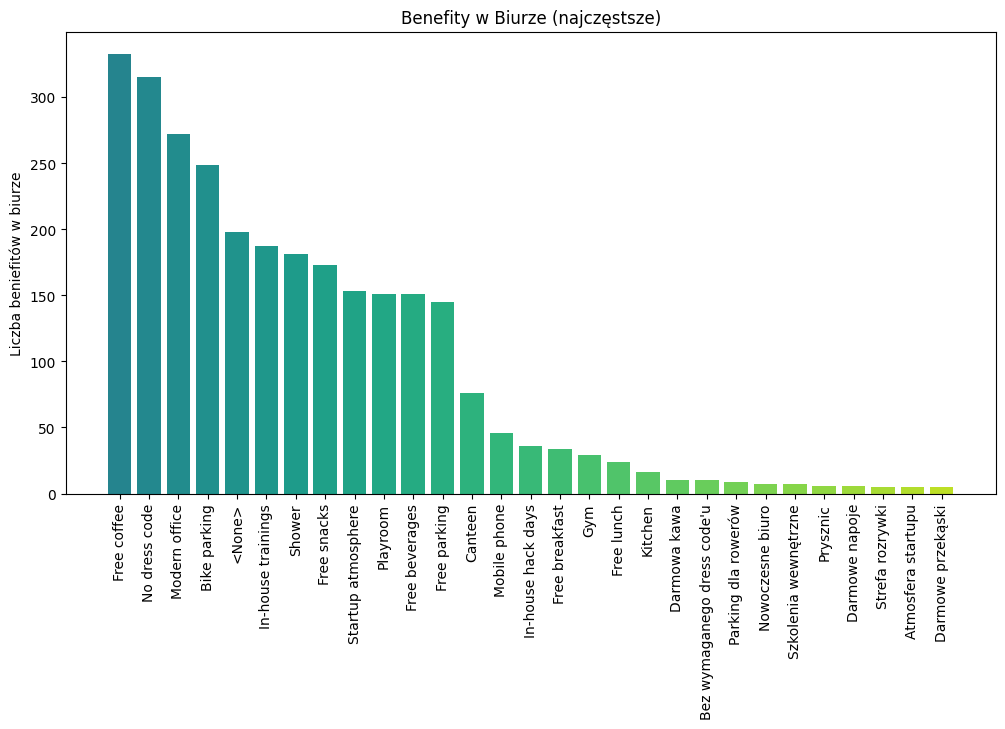

In [87]:
def perks_ctr(df):
    counter = Counter()
    
    for loc in df['perks_in_the_office']:
        for sub_loc in loc.split(", "):
            counter[sub_loc] += 1


    # Filtruj tagi, które wystąpiły mniej niż 5 razy
    filtered_data = {k: v for k, v in counter.items() if v >= 5}

    # Sortuj dane w malejącej kolejności
    sorted_data = dict(sorted(filtered_data.items(), key=lambda x: x[1], reverse=True))
    
    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba beniefitów w biurze')
    plt.title('Benefity w Biurze (najczęstsze)')
    plt.show()

perks_ctr(df)


### General benefits for IT jobs

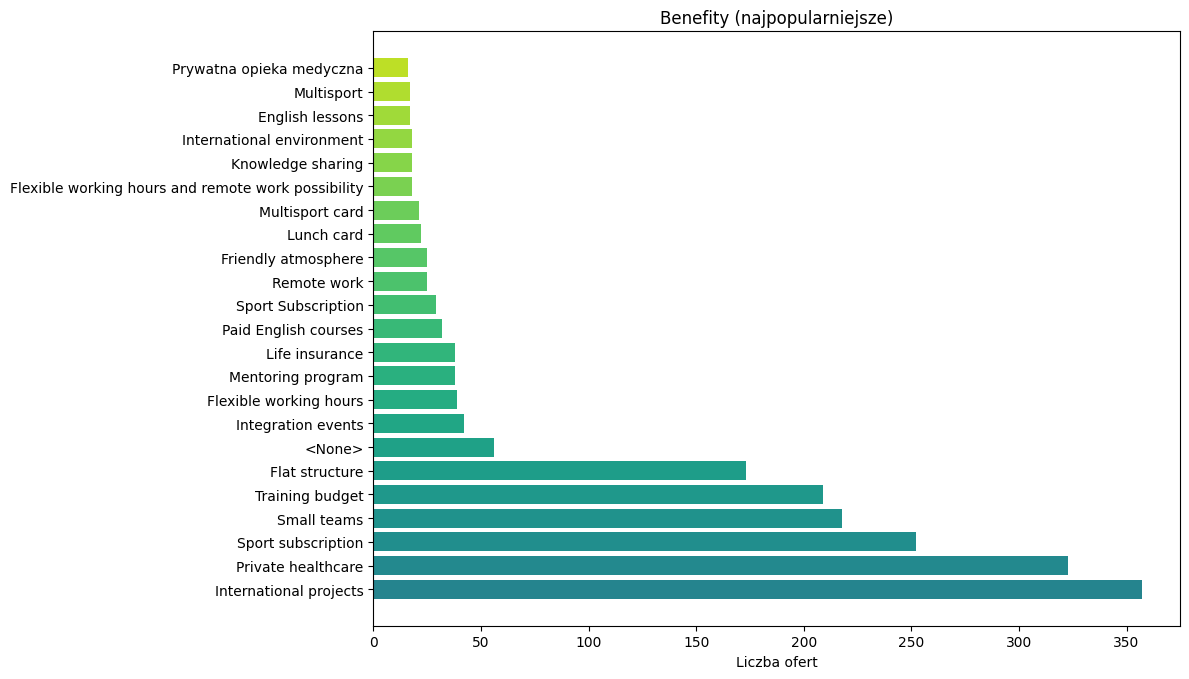

In [80]:
def benefits_ctr(df):
    counter = Counter()
    
    for loc in df['benefits']:
        for sub_loc in loc.split(", "):
            counter[sub_loc] += 1

    # Filtruj tagi, które wystąpiły mniej niż 5 razy
    filtered_data = {k: v for k, v in counter.items() if v >= 15}

    # Sortuj dane w malejącej kolejności
    sorted_data = dict(sorted(filtered_data.items(), key=lambda x: x[1], reverse=True))
    
    # Oblicz wysokość wykresu proporcjonalnie do liczby kolumn
    height = len(sorted_data) * 0.3  # 0.3 to przykładowa wartość dla każdej kolumny, możesz ją dostosować
    plt.figure(figsize=(12, height))

    # Generowanie palety kolorów
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    # Tworzenie wykresu z paletą kolorów
    plt.barh(list(sorted_data.keys()), list(sorted_data.values()), color=colors)
    plt.xlabel('Liczba ofert')
    plt.title('Benefity (najpopularniejsze)')
    plt.tight_layout()  # Aby poprawić wygląd wykresu
    plt.show()

# Możesz teraz użyć funkcji benefits_ctr, przekazując jej df jako argument
benefits_ctr(df)


### Companies foundation time

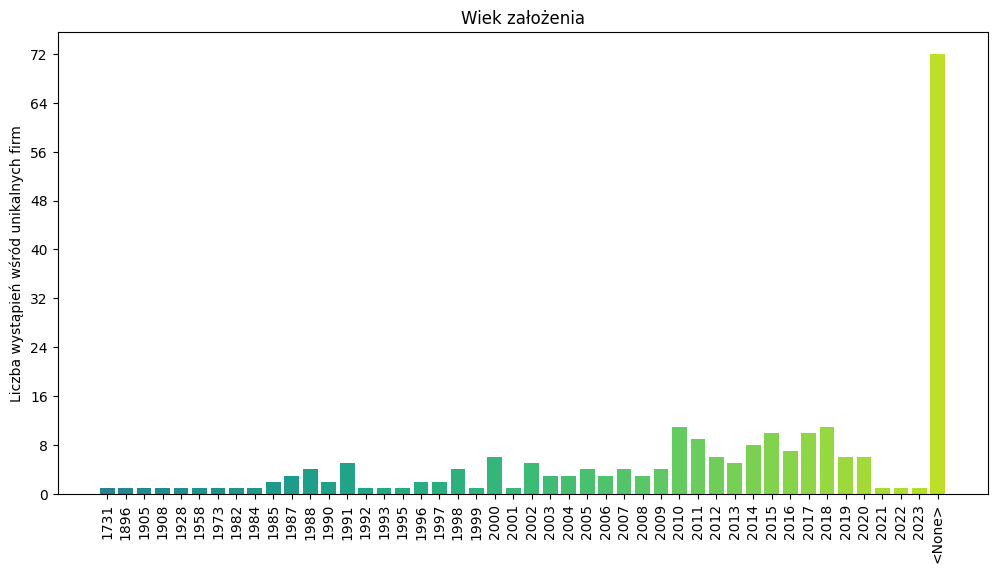

In [68]:
def unique_company_age_ctr(df):
    counter = Counter()
    once_mentioned = set()
    
    for index, row in df.iterrows():
        company = row['company']
        founded_in = row['company_foundation_year']
        
        if company not in once_mentioned:
            counter[founded_in] += 1
            once_mentioned.add(company)

    # Podziel klucze na te, które są czterocyfrowymi liczbami, i na pozostałe
    numeric_keys = [key for key in counter.keys() if isinstance(key, str) and key.isdigit() and len(key) == 4]
    non_numeric_keys = [key for key in counter.keys() if key not in numeric_keys]
    
    # Posortuj obie listy kluczy
    numeric_keys = sorted(numeric_keys, key=int)
    non_numeric_keys = sorted(non_numeric_keys)
    
    # Połącz posortowane listy kluczy
    sorted_keys = numeric_keys + non_numeric_keys
    
    # Utwórz posortowany słownik
    sorted_data = {key: counter[key] for key in sorted_keys}
    
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    
    plt.ylabel('Liczba wystąpień wśród unikalnych firm')
    plt.title('Wiek założenia')
    
    # Ustawienie formatu osi Y, aby wyświetlać tylko liczby całkowite
    ax = plt.gca()
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.show()

# Zakładam, że masz już wcześniej zdefiniowane df
unique_company_age_ctr(df)


### Size of companies (by number of employees)

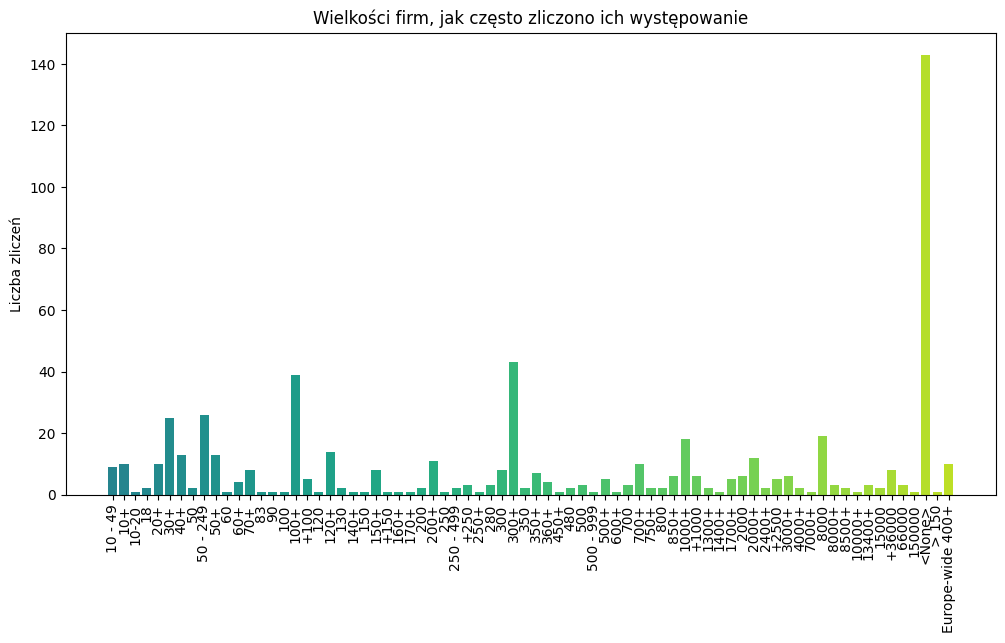

In [69]:
# Funkcja pomocnicza do konwersji tekstu na wartości liczbowe, gdzie to możliwe
def atoi(text):
    return int(text) if text.isdigit() else text

# Funkcja do sortowania tekstów zawierających liczby w sposób naturalny
def natural_keys(text):
    # Usunięcie spacji między cyframi
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    # Przeniesienie znaku "+" na koniec, jeśli jest na początku
    text = re.sub(r'^\+(\d+)', r'\1+', text)
    # Sortowanie naturalne
    return [atoi(c) for c in re.split(r'(\d+)', text)]

def string_only_size_ctr(df):
    counter = Counter()
    
    for loc in df['company_size']:
        if isinstance(loc, str):  # Tylko jeśli wartość to łańcuch znaków
            counter[loc] += 1

    # Sortuj dane według klucza (wielkości firm), z uwzględnieniem zmodyfikowanych reguł
    sorted_data = dict(sorted(counter.items(), key=lambda x: natural_keys(x[0])))

    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba zliczeń')
    plt.title('Wielkości firm, jak często zliczono ich występowanie')
    plt.show()

# Wywołanie zmodyfikowanej funkcji
string_only_size_ctr(df)



### Companies HQs

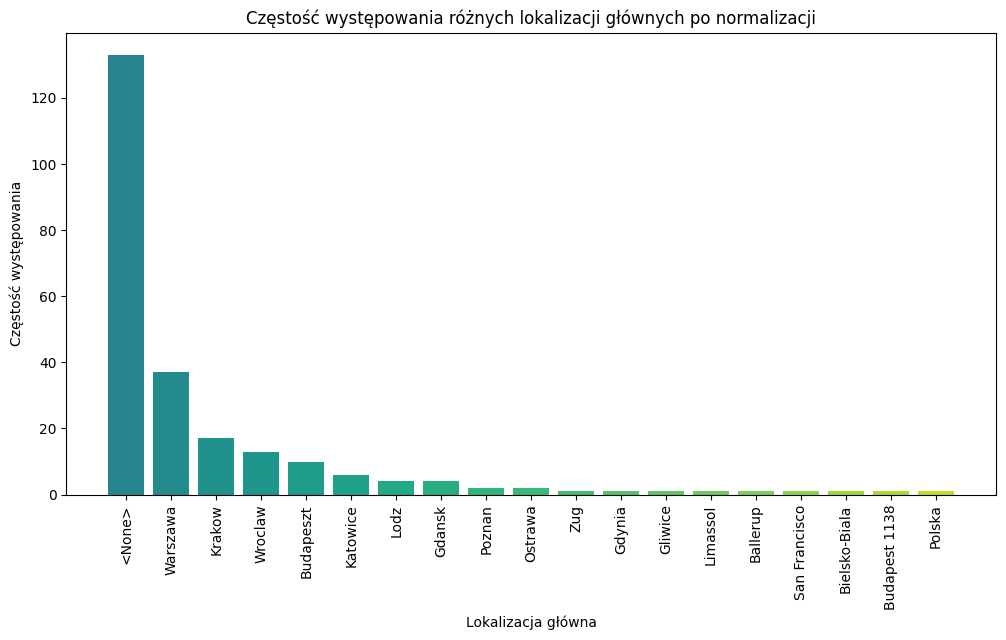

In [70]:
# Funkcje pomocnicze z drugiego kodu
def format_location(loc):
    loc = re.sub(r'\s*-\s*', '-', loc)
    return unidecode.unidecode(loc).title()

def get_polish_name(city_name):
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "language": "en",
        "format": "json",
        "search": city_name
    }
    response = requests.get(url, params=params)
    results = response.json().get('search')

    if not results:
        return None

    city_id = results[0].get('id')
    if not city_id:
        return None

    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbgetentities",
        "ids": city_id,
        "format": "json",
        "props": "labels",
        "languages": "pl"
    }
    response = requests.get(url, params=params)
    data = response.json()

    polish_name = data['entities'][city_id]['labels'].get('pl')
    if polish_name:
        return polish_name.get('value')
    else:
        return None

def process_locations(counter):
    processed_counter = Counter()
    for loc, count in counter.items():
        if loc.lower() in ["remote", "hybrid"]:
            processed_counter[loc] += count
            continue

        polish_name = get_polish_name(loc)
        if polish_name:
            formatted_polish_name = format_location(polish_name)
            processed_counter[formatted_polish_name] += count
        else:
            formatted_loc = format_location(loc)
            processed_counter[formatted_loc] += count

    return processed_counter

# Modyfikacja pierwszego kodu
# Załóżmy, że df to DataFrame z Twoimi danymi
first_occurrences = df.drop_duplicates(subset='company')
location_counts = first_occurrences['company_head_office_place'].value_counts()

# Przetworzenie danych
counter = Counter(location_counts.to_dict())
processed_counter = process_locations(counter)

# Sortowanie i tworzenie wykresu
sorted_data = dict(sorted(processed_counter.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))

# Tworzenie palety kolorów dla słupków
colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))


# Użycie wygenerowanej palety kolorów dla słupków
plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
plt.xticks(rotation=90)
plt.ylabel('Częstość występowania')
plt.xlabel('Lokalizacja główna')
plt.title('Częstość występowania różnych lokalizacji głównych po normalizacji')
plt.show()


### Time of offers publication (sample)

In [71]:
def analyze_when_published(row):
    if "This offer expires" in row['when_published_relatively']:
        # Szukaj dwucyfrowej liczby
        match = re.search(r'\b\d{2}\b', row['when_published_relatively'])
        if not match:
            # Jeśli nie znaleziono dwucyfrowej liczby, szukaj jednocyfrowej
            match = re.search(r'\b\d\b', row['when_published_relatively'])
        if match:
            row['date_of_issueing_no'] = str(30 - int(match.group()))
        else:
            row['date_of_issueing_no'] = 'UnknownError'
    elif not row['when_published_relatively'] or row['when_published_relatively'] == "UnknownError":
        row['date_of_issueing_no'] = 'UnknownError'
    elif 'today' in row['when_published_relatively']:
        row['date_of_issueing_no'] = '0'
    else:
        digits = max(''.join(filter(str.isdigit, word)) for word in row['when_published_relatively'].split())
        if not digits:
            row['date_of_issueing_no'] = 'UnknownError'
        else:
            row['date_of_issueing_no'] = digits
    return row

df = df.apply(analyze_when_published, axis=1)

def calculate_date_of_issueing(row):
    if row['date_of_issueing_no'] == 'UnknownError':
        return 'UnknownError'
    else:
        date_result = pd.to_datetime(row['date_of_scrapping']) - timedelta(days=int(row['date_of_issueing_no']))
        return date_result.normalize().strftime('%Y-%m-%d')  # Tutaj konwertujemy datę na ciąg znaków w formacie yyyy-mm-dd


df['date_of_issueing'] = df.apply(calculate_date_of_issueing, axis=1)

result_df = df[['id', 'date_of_scrapping', 'when_published_relatively', 'date_of_issueing', 'date_of_issueing_no']]
pd.set_option('display.max_rows', 30)
result_df


,id,date_of_scrapping,when_published_relatively,date_of_issueing,date_of_issueing_no
0,1,2023-11-21,Oferta opublikowana dzisiaj,UnknownError,UnknownError
1,2,2023-11-21,today,2023-11-21,0
2,3,2023-11-21,This offer expires in 1 day,2023-10-23,29
3,4,2023-11-21,This offer expires in 1 day,2023-10-23,29
4,5,2023-11-21,5 days ago,2023-11-16,5
...,...,...,...,...,...
581,582,2023-11-29,Hurry up! This offer expires soon,UnknownError,UnknownError
582,583,2023-11-29,4 days ago,2023-11-25,4
583,584,2023-11-29,This offer expires in 3 days,2023-11-02,27
584,585,2023-11-29,2 days ago,2023-11-27,2


### IT job offers categories

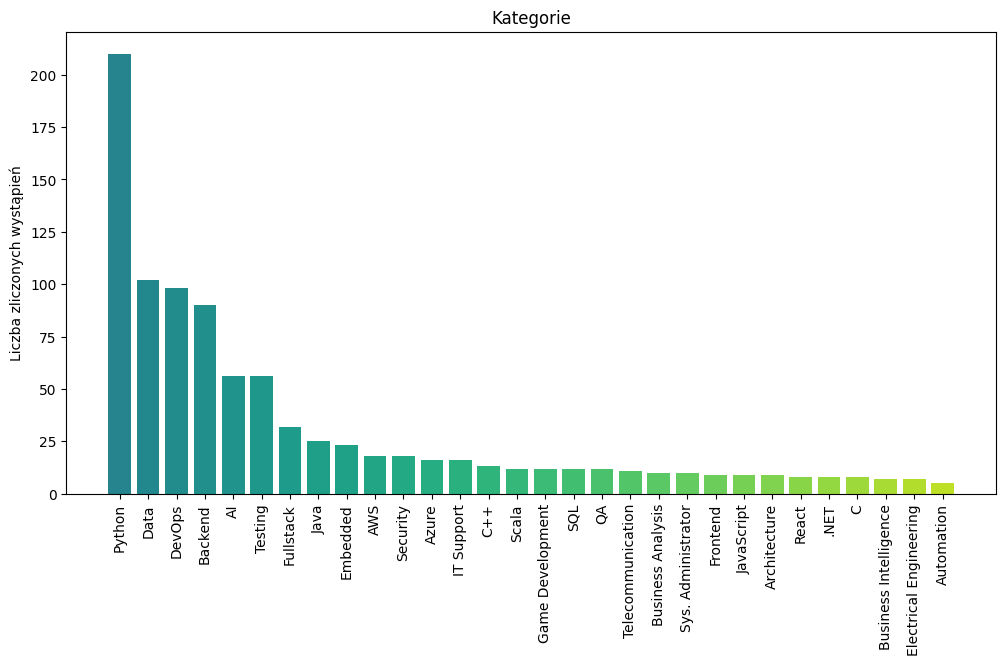

In [86]:
def categories_ctr(df):
    counter = Counter()
    
    for loc in df['categories']:
        for sub_loc in loc.split(", "):
            counter[sub_loc] += 1

    # Filtruj tagi, które wystąpiły mniej niż 5 razy
    filtered_data = {k: v for k, v in counter.items() if v >= 5}

    # Sortuj dane w malejącej kolejności
    sorted_data = dict(sorted(filtered_data.items(), key=lambda x: x[1], reverse=True))
                
    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba zliczonych wystąpień')
    plt.title('Kategorie')
    plt.show()

categories_ctr(df)


### Seniority frequency in job offers

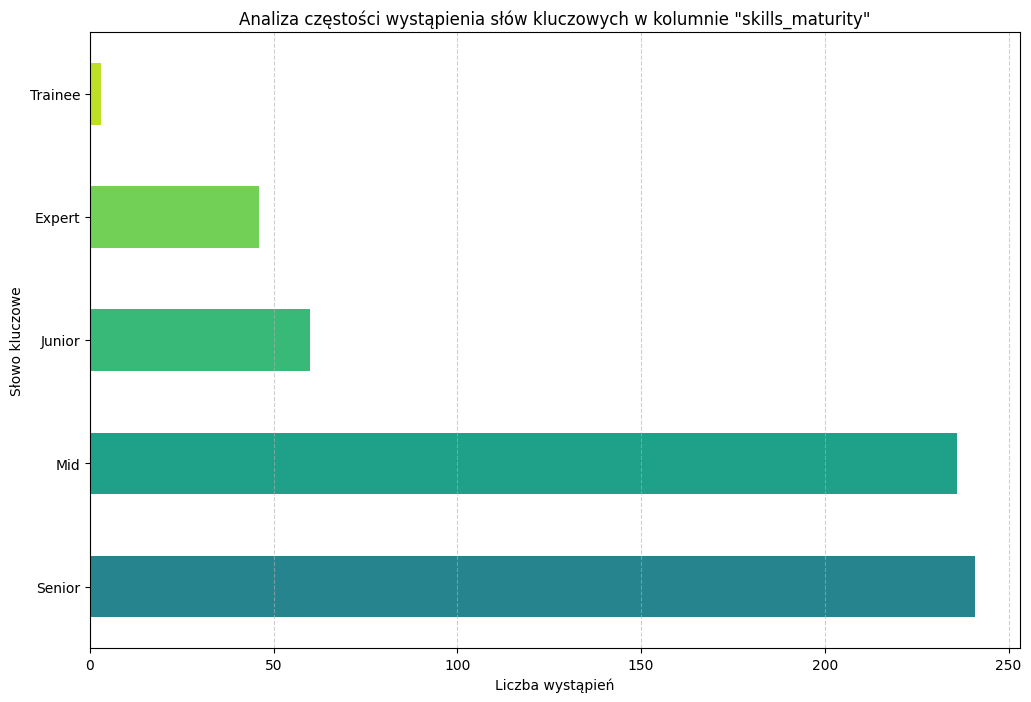

In [73]:
def analyze_keyword_frequency(dataframe, column_name="skills_maturity"):
    # Sprawdź, czy kolumna istnieje w ramce danych
    if column_name not in dataframe.columns:
        print(f'Kolumna "{column_name}" nie istnieje w ramce danych.')
        return

    # Zliczenie częstości wystąpienia słów kluczowych
    keyword_counts = dataframe[column_name].value_counts()

    # Tworzenie wizualizacji
    plt.figure(figsize=(12, 8))

    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(keyword_counts)))

    # Użycie wygenerowanej palety kolorów dla słupków
    keyword_counts.plot(kind='barh', color=colors)
    
    plt.xlabel('Liczba wystąpień')
    plt.ylabel('Słowo kluczowe')
    plt.title(f'Analiza częstości wystąpienia słów kluczowych w kolumnie "{column_name}"')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# Przykład użycia
analyze_keyword_frequency(df, 'skills_maturity')


### Mandatory skills for the positions

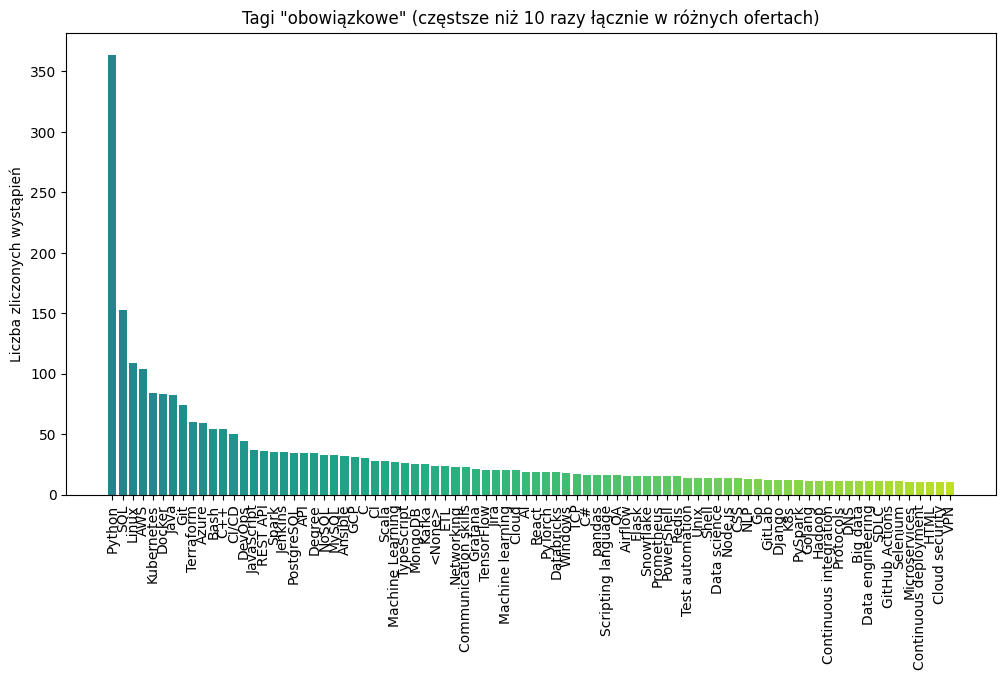

In [74]:
def tags_mandatory_ctr(df):
    counter = Counter()
    
    for loc in df['tags_mandatory']:
        for sub_loc in loc.split(", "):
            counter[sub_loc] += 1

    # Filtruj tagi, które wystąpiły mniej niż 10 razy
    filtered_data = {k: v for k, v in counter.items() if v >= 10}

    # Sortuj dane w malejącej kolejności
    sorted_data = dict(sorted(filtered_data.items(), key=lambda x: x[1], reverse=True))
                
    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba zliczonych wystąpień')
    plt.title('Tagi "obowiązkowe" (częstsze niż 10 razy łącznie w różnych ofertach)')
    plt.show()

# Przykład użycia
tags_mandatory_ctr(df)


### "Nice to have" skills for the positions

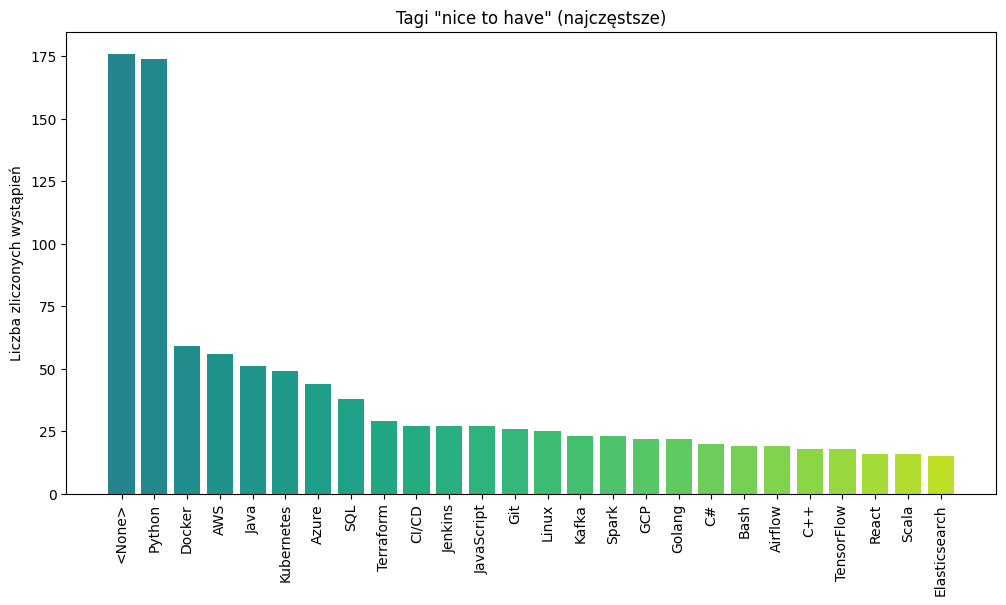

In [75]:
def tags_nice_to_have_ctr(df):
    counter = Counter()
    
    for loc in df['tags_nice_to_have']:
        for sub_loc in loc.split(", "):
            counter[sub_loc] += 1

    # Filtruj tagi, które wystąpiły mniej niż 3 razy
    filtered_data = {k: v for k, v in counter.items() if v >= 15}

    # Sortuj dane w malejącej kolejności
    sorted_data = dict(sorted(filtered_data.items(), key=lambda x: x[1], reverse=True))
                
    # Tworzenie wykresu
    plt.figure(figsize=(12, 6))
    
    # Tworzenie palety kolorów dla słupków
    colors = plt.cm.viridis(np.linspace(0.45, 0.9, len(sorted_data)))

    
    # Użycie wygenerowanej palety kolorów dla słupków
    plt.bar(sorted_data.keys(), sorted_data.values(), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel('Liczba zliczonych wystąpień')
    plt.title('Tagi "nice to have" (najczęstsze)')
    plt.show()

# Przykład użycia
tags_nice_to_have_ctr(df)
